In [402]:
import pandas as pd
from itertools import combinations
import networkx as nx
import pandas as pd
import networkx as nx
from community import best_partition
from collections import defaultdict
import matplotlib.pyplot as plt
from matplotlib.cm import tab20
import matplotlib.pyplot as plt
import community as louvain  # python-louvain库
from collections import Counter

In [403]:
# 读取数据并分组
df = pd.read_csv(r'C:\Users\Chen Ray\Skills-Assessment-2\outputs\authors_cleaned.csv')
papers = df.groupby("PMID")["AuthorFullName"].apply(list)


In [404]:
# 构建合作网络
G = nx.Graph()
for authors in papers:
    for pair in combinations(authors, 2):
        if pair[0] != pair[1]:  # 避免添加自环
            if G.has_edge(*pair):
                G[pair[0]][pair[1]]["weight"] += 1
            else:
                G.add_edge(pair[0], pair[1], weight=1)


In [405]:
# 计算中心性指标
degree = nx.degree_centrality(G)
betweenness = nx.betweenness_centrality(G, k=100)  # 抽样加速计算
eigenvector = nx.eigenvector_centrality(G, max_iter=1000)


In [406]:
# 输出结果
print("度中心性 Top 5:", sorted(degree.items(), key=lambda x: -x[1])[:5])
print("中介中心性 Top 5:", sorted(betweenness.items(), key=lambda x: -x[1])[:5])
print("特征向量中心性 Top 5:", sorted(eigenvector.items(), key=lambda x: -x[1])[:5])

度中心性 Top 5: [('John Hardy', 0.03471966629861367), ('Henrik Zetterberg', 0.033738191632928474), ('Jonathan L Haines', 0.0326647037173353), ('Cornelia M van Duijn', 0.032081953134584715), ('Margaret A Pericak-Vance', 0.03195926880137406)]
中介中心性 Top 5: [('Magda Tsolaki', 0.12339082267916902), ('John Hardy', 0.02196986002614934), ('J Wouter Jukema', 0.018764252806670455), ('Paul M Thompson', 0.017656661752304063), ('Pedro Moral', 0.01588399481705636)]
特征向量中心性 Top 5: [('Hilkka Soininen', 0.05277352312411625), ('Cornelia M van Duijn', 0.052529110906804656), ('Jonathan L Haines', 0.05217923212227738), ('Jean-Charles Lambert', 0.052054550450647455), ('Philippe Amouyel', 0.05205047124263068)]


In [407]:
# 使用Louvain算法检测社区
partition = louvain.best_partition(G, resolution=1.0)  # resolution参数控制社区粒度
nx.set_node_attributes(G, partition, "community")

In [408]:
# 假设已通过Louvain算法获得社区划分 partition
community_counts = Counter(partition.values())
top_10_communities = [com for com, _ in community_counts.most_common(3000)]  # 按节点数量选取前10社区

In [409]:
top_authors = []

for com in top_10_communities:
    # 提取该社区所有作者
    community_nodes = [n for n in G.nodes if G.nodes[n]["community"] == com]
    
    # 计算社区内度中心性
    subgraph = G.subgraph(community_nodes)
    degree_centrality = nx.degree_centrality(subgraph)
    
    # 选取度中心性最高的作者
    top_author = max(degree_centrality, key=degree_centrality.get)
    top_authors.append(top_author)

In [410]:
# 创建仅包含前十大社区核心作者的子图
simplified_G = G.subgraph(top_authors).copy()

# 添加跨社区边权重（可选）
for u, v in simplified_G.edges():
    original_weight = G[u][v]["weight"] if G.has_edge(u, v) else 1
    simplified_G[u][v]["weight"] = original_weight

In [411]:
# 删除没有连线的社区
simplified_G.remove_nodes_from(list(nx.isolates(simplified_G)))

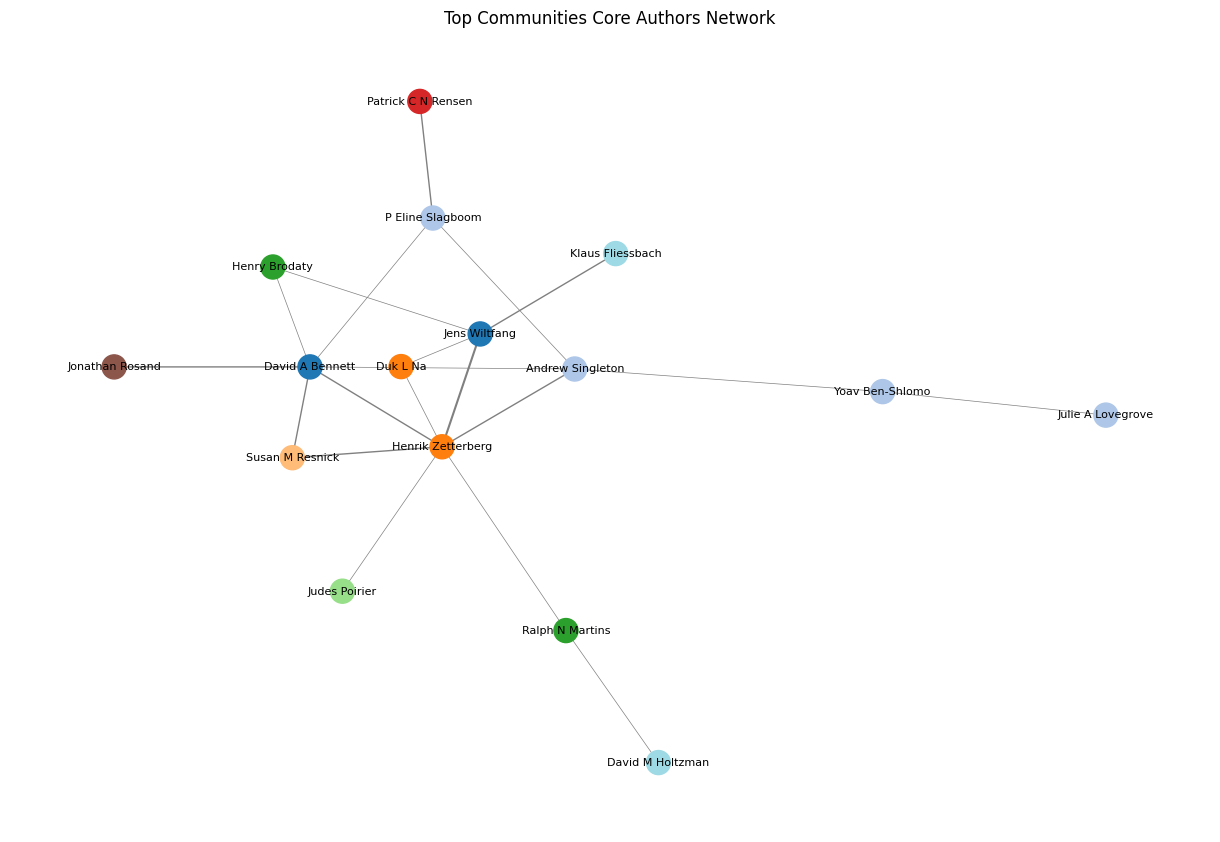

In [412]:
# 设置布局和样式
pos = nx.spring_layout(simplified_G, k=0.5, seed=42)  # 降低k值减少节点间距
node_colors = [partition[author] for author in simplified_G.nodes()]
edge_widths = [simplified_G[u][v]["weight"]*0.5 for u, v in simplified_G.edges()]

# 绘制网络
plt.figure(figsize=(12, 8))
nx.draw(simplified_G, pos, 
        node_color=node_colors, 
        cmap=plt.cm.tab20,
        with_labels=True,
        edge_color="grey",
        width=edge_widths,
        font_size=8)
plt.title("Top Communities Core Authors Network")
plt.show()